<a href="https://colab.research.google.com/github/lakshyasahu111/Vision-Transformer-From-Scratch/blob/main/Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Importing Required Libraries

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
import numpy as np
import matplotlib.pyplot as plt
import random

# 2. Setup of device agnostic code

In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"

# 3. Set the seed

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)


# 4. Setting up the hyperparameters

In [ ]:
BATCH_SIZE=128
EPOCHS=5
LEARNING_RATE=1e-3
PATCH_SIZE=4
NUM_CLASSES=10
IMAGE_SIZE=32
CHANNELS=3
EMBED_DIM=256
NUM_HEADS=8
DEPTH=6
MLP_DIM=512
DROP_RATE=0.1


# 5. Define Image Transformations

## Using Augmentation

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

#6. Getting a Dataset

In [ ]:
train_dataset=datasets.CIFAR10(root="data",
                               train=True,
                               download=True,
                               transform=train_transform)
test_dataset=datasets.CIFAR10(root="data",
                               train=False,
                               download=True,
                               transform=test_transform)

#7. Converting our Dataset into dataloaders

In [ ]:
train_loader=DataLoader(dataset=train_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True)
test_loader=DataLoader(dataset=test_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False)

#8. Building Vision Tranformer Model from Scratch(Logic)

In [ ]:
# Patch Embedding Layer
class PatchEmbedding(nn.Module):
  def __init__(self,
               img_size,
               patch_size,
               in_channels,
               embed_dim):
    super().__init__()
    self.patch_size=patch_size
    self.proj=nn.Conv2d(in_channels=in_channels,
                        out_channels=embed_dim,
                        kernel_size=patch_size,
                        stride=patch_size)
    num_patches=(img_size//patch_size)**2
    self.cls_token=nn.Parameter(torch.randn(1,1,embed_dim))
    self.pos_embed=nn.Parameter(torch.randn(1,1+num_patches,embed_dim))

  def forward(self,x: torch.Tensor):
      B=x.size(0)
      x=self.proj(x) # (B,E,H/P,W/P)
      x=x.flatten(2).transpose(1,2) # (B,N,E)
      cls_token=self.cls_token.expand(B,-1,-1)
      x=torch.cat((cls_token,x),dim=1)
      x=x+self.pos_embed
      return x

In [ ]:
class MLP(nn.Module):
  def __init__(self,
               in_features,
               hidden_features,
               drop_rate):
      super().__init__()
      self.fc1=nn.Linear(in_features=in_features,
                         out_features=hidden_features)
      self.fc2=nn.Linear(in_features=hidden_features,
                         out_features=in_features)
      self.dropout=nn.Dropout(drop_rate)
  def forward(self,x):
    x=self.dropout(F.gelu(self.fc1(x)))
    x=self.dropout(self.fc2(x))
    return x



In [ ]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self,embed_dim,num_heads,mlp_dim,drop_rate):
       super().__init__()
       self.norm1=nn.LayerNorm(embed_dim)
       self.attn=nn.MultiheadAttention(embed_dim,num_heads=num_heads,dropout=drop_rate,batch_first=True)
       self.norm2=nn.LayerNorm(embed_dim)
       self.mlp=MLP(embed_dim,mlp_dim,drop_rate)

  def forward(self, x):
        # # FIXED: MultiheadAttention returns (output, weights), we need [0]
        # attn_out, _ = self.self_attn(self.norm1(x), self.norm1(x), self.norm1(x))
        # x = x + attn_out
        # x = x + self.mlp(self.norm2(x))
        # return x
        x=x+self.attn(self.norm1(x),self.norm1(x),self.norm1(x))[0]
        x=x+self.mlp(self.norm2(x))
        return x



In [ ]:
class VisionTransformer(nn.Module):
  def __init__(self,img_size,patch_size,in_channels,num_classes,embed_dim,num_heads,depth,mlp_dim,drop_rate):
    super().__init__()
    self.patch_embed=PatchEmbedding(img_size,patch_size,in_channels,embed_dim)
    self.encoder=nn.Sequential(*[
        TransformerEncoderLayer(embed_dim,num_heads,mlp_dim,drop_rate)
        for _ in range(depth)
    ])
    self.norm=nn.LayerNorm(embed_dim)
    self.head=nn.Linear(embed_dim,num_classes)

  def forward(self,x):
    x=self.patch_embed(x)
    x=self.encoder(x)
    x=self.norm(x)
    cls_token=x[:,0]
    return self.head(cls_token)

In [ ]:
model = VisionTransformer(
    img_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    in_channels=CHANNELS,
    num_classes=NUM_CLASSES,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,  # Now 256 / 8 = 32 (Valid)
    depth=DEPTH,
    mlp_dim=MLP_DIM,
    drop_rate=DROP_RATE
).to(device)

#9. Defining the loss function and Optimizer

In [ ]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=LEARNING_RATE)

#10. Defining a training loop function

In [ ]:
def train(model,loader,optimizer,criterion):
  model.train()
  total_loss,correct=0,0
  for x,y in loader:
    x,y=x.to(device),y.to(device)
    optimizer.zero_grad()
    out=model(x)
    loss=criterion(out,y)
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()*x.size(0)
    correct+=(out.argmax(1)==y).sum().item()
  return total_loss/len(loader.dataset),correct/len(loader.dataset)

In [ ]:
def evaluate(model,loader):
  model.eval()
  correct=0
  with torch.inference_mode():
    for x,y in loader:
      x,y=x.to(device),y.to(device)
      out=model(x)
      correct+=(out.argmax(dim=1)==y).sum().item()
  return correct/len(loader.dataset)

In [ ]:
from tqdm.auto import tqdm

In [ ]:
### Training
train_accuracies=[]
test_accuracies=[]

for epoch in tqdm(range(EPOCHS)):
  train_loss,train_acc=train(model,train_loader,optimizer,criterion)
  test_acc=evaluate(model,test_loader)
  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)
  print(f"EPOCH:{epoch+1}/{EPOCHS}, Train Loss: {train_loss: .4f},Train acc:{train_acc: .4f},Test Acc: {test_acc:.4f}")

  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH:1/50, Train Loss:  1.5635,Train acc: 0.4271,Test Acc: 0.4815
EPOCH:2/50, Train Loss:  1.5004,Train acc: 0.4530,Test Acc: 0.4767
EPOCH:3/50, Train Loss:  1.4590,Train acc: 0.4698,Test Acc: 0.5178
EPOCH:4/50, Train Loss:  1.4336,Train acc: 0.4755,Test Acc: 0.5261
EPOCH:5/50, Train Loss:  1.4064,Train acc: 0.4866,Test Acc: 0.5179
EPOCH:6/50, Train Loss:  1.3739,Train acc: 0.4992,Test Acc: 0.5294
EPOCH:7/50, Train Loss:  1.3434,Train acc: 0.5126,Test Acc: 0.5507
EPOCH:8/50, Train Loss:  1.3145,Train acc: 0.5219,Test Acc: 0.5579
EPOCH:9/50, Train Loss:  1.2814,Train acc: 0.5343,Test Acc: 0.5587
EPOCH:10/50, Train Loss:  1.2471,Train acc: 0.5474,Test Acc: 0.5815
EPOCH:11/50, Train Loss:  1.2161,Train acc: 0.5597,Test Acc: 0.5933
EPOCH:12/50, Train Loss:  1.1684,Train acc: 0.5763,Test Acc: 0.6039
EPOCH:13/50, Train Loss:  1.1246,Train acc: 0.5944,Test Acc: 0.6281
EPOCH:14/50, Train Loss:  1.0765,Train acc: 0.6132,Test Acc: 0.6392
EPOCH:15/50, Train Loss:  1.0349,Train acc: 0.6290,Test A

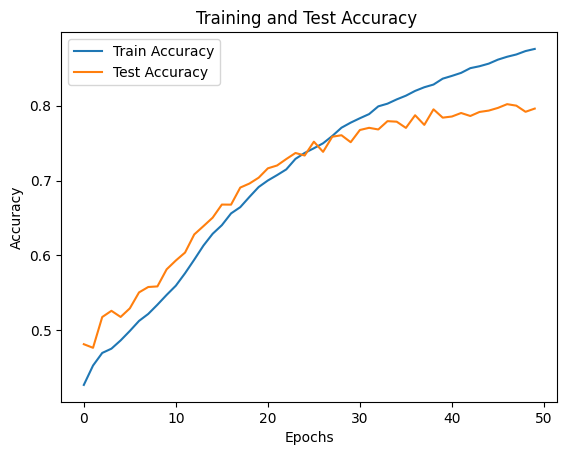

In [ ]:
plt.plot(train_accuracies,label="Train Accuracy")
plt.plot(test_accuracies,label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Test Accuracy ")
plt.show()

In [ ]:
def predict_and_plot_grid(model,dataset,classes,grid_size=3):
  model.eval()
  fig,axes=plt.subplots(grid_size,grid_size,figsize=(9,9))
  for i in range(grid_size):
    for j in range(grid_size):
      idx=random.randint(0,len(dataset)-1)
      img,true_label=dataset[idx]
      input_tensor=img.unsqueeze(dim=0).to(device)
      with torch.inference_mode():
        output=model(input_tensor)
        _,predicted=torch.max(output.data,1)
      img=img/2+0.5
      npimg=img.cpu().numpy()
      axes[i,j].imshow(np.transpose(npimg,(1,2,0)))
      truth=classes[true_label]==classes[predicted.item()]
      if truth:
        color="g"
      else:
        color="r"
      axes[i,j].set_title(f"True:{classes[true_label]},\nPred:{classes[predicted.item()]}",fontsize=9,color=color)
      axes[i,j].axis("off")
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
def predict_and_plot_grid(model, dataset, classes, grid_size=3):
    model.eval()
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(9, 9))

    # CIFAR-10 specific constants for denormalization
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])

    for i in range(grid_size):
        for j in range(grid_size):
            idx = random.randint(0, len(dataset) - 1)
            img, true_label = dataset[idx]

            # 1. Denormalize the image for display
            # Formula: image = (tensor * std) + mean
            npimg = img.cpu().numpy().transpose((1, 2, 0)) # Change to (H, W, C)
            npimg = std * npimg + mean
            npimg = np.clip(npimg, 0, 1) # Force range to [0, 1] for safety

            # 2. Get Prediction
            input_tensor = img.unsqueeze(dim=0).to(device)
            with torch.inference_mode():
                output = model(input_tensor)
                _, predicted = torch.max(output.data, 1)

            # 3. Plot
            axes[i, j].imshow(npimg)

            is_correct = true_label == predicted.item()
            color = "g" if is_correct else "r"
            axes[i, j].set_title(f"True Label:{classes[true_label]}\nPredicted Lable:{classes[predicted.item()]}",
                                 fontsize=9, color=color)
            axes[i, j].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
predict_and_plot_grid(model,test_dataset,classes=train_dataset.classes,grid_size=3)